# Machine learning for Medicine
## Lab V - Implementing a Logistic Regression algorithm: Applications to medical field

*Badis Jaouani - M2 Stat*
___

In this lab, the aim is to understand and implement a Logistic Regression Classifier. This is a linear classifier that has been used as a basis to understand and build more advanced architectures such as Neural Networks. 

As many Machine Learning algorithms, Logistic Regression boils down to a minimization of a loss function, the logistic loss, which can be solved by first order methods, mainly gradient descent, or by second order methods, namely Newton methods.

In this lab, the used algorithm for the optimization problem is the Stochastic Gradient Descent, known for its effectiveness and its reduced computational complexity. For detailed information about Logistic regression and Stochastic Gradient Descent, one can consult the dedicated pages on scikit-learn's website: https://scikit-learn.org/0.16/modules/linear_model.html#logistic-regression.



# Table of Contents
___

1. [Logistic Regression on simulated data sets](#Import)
    - [Data sets construction](#Import)
    - [Logistic Regression Classifier from scikit-learn](#Import)
    - [Applying k-fold cross-validation](#Import)

2. [Logistic Regression Implementation](#Import)

3. [Test on simulated data sets](#Import)
    - [Binary classification](#Import)
    - [Multi-class classification](#Download_data)
    - [Moon data set](#X)  
    - [$k$-cross-validation on binary classification data sets $(k=10)$](#Download_data)
    - [$k$-cross-validation on the multi-class classification data set $(k=10)$](#X) 
    
4. [Mice Protein Expression data set](#Import)
5. [Breast Cancer Diagnosis](#Import)

In [1]:
from mllab import *


Packages:
	nympy as np
	matplotlib.pyplot as plt
	seaborn as sns

Functions:
	plotXY
	plot_frontiere
	map_regions
	covariance
	plot_cov
	sample_gmm
	scatter
	plot_level_set
	gaussian_sample



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
sns.set_style('whitegrid')

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import make_classification, make_blobs, make_moons

# 1. Logistic Regression on simulated data sets
___
We start as usual by constructing our toy data sets, for which decision boundaries are easily interpretable.

## 1.1) Data sets construction

In [3]:
# Fisrt dataset
X1, y1 = make_classification(n_samples = 200, n_features = 2, 
                             n_informative = 2, n_classes = 2,
                             n_clusters_per_class = 1, n_redundant = 0, random_state = 0)
# Second dataset
X2, y2 = make_blobs(n_samples = 200, n_features = 2, 
                    centers = 3, random_state = 0)
# Third dataset
X3, y3 = make_moons(n_samples = 200, noise = 0.08, random_state = 0)

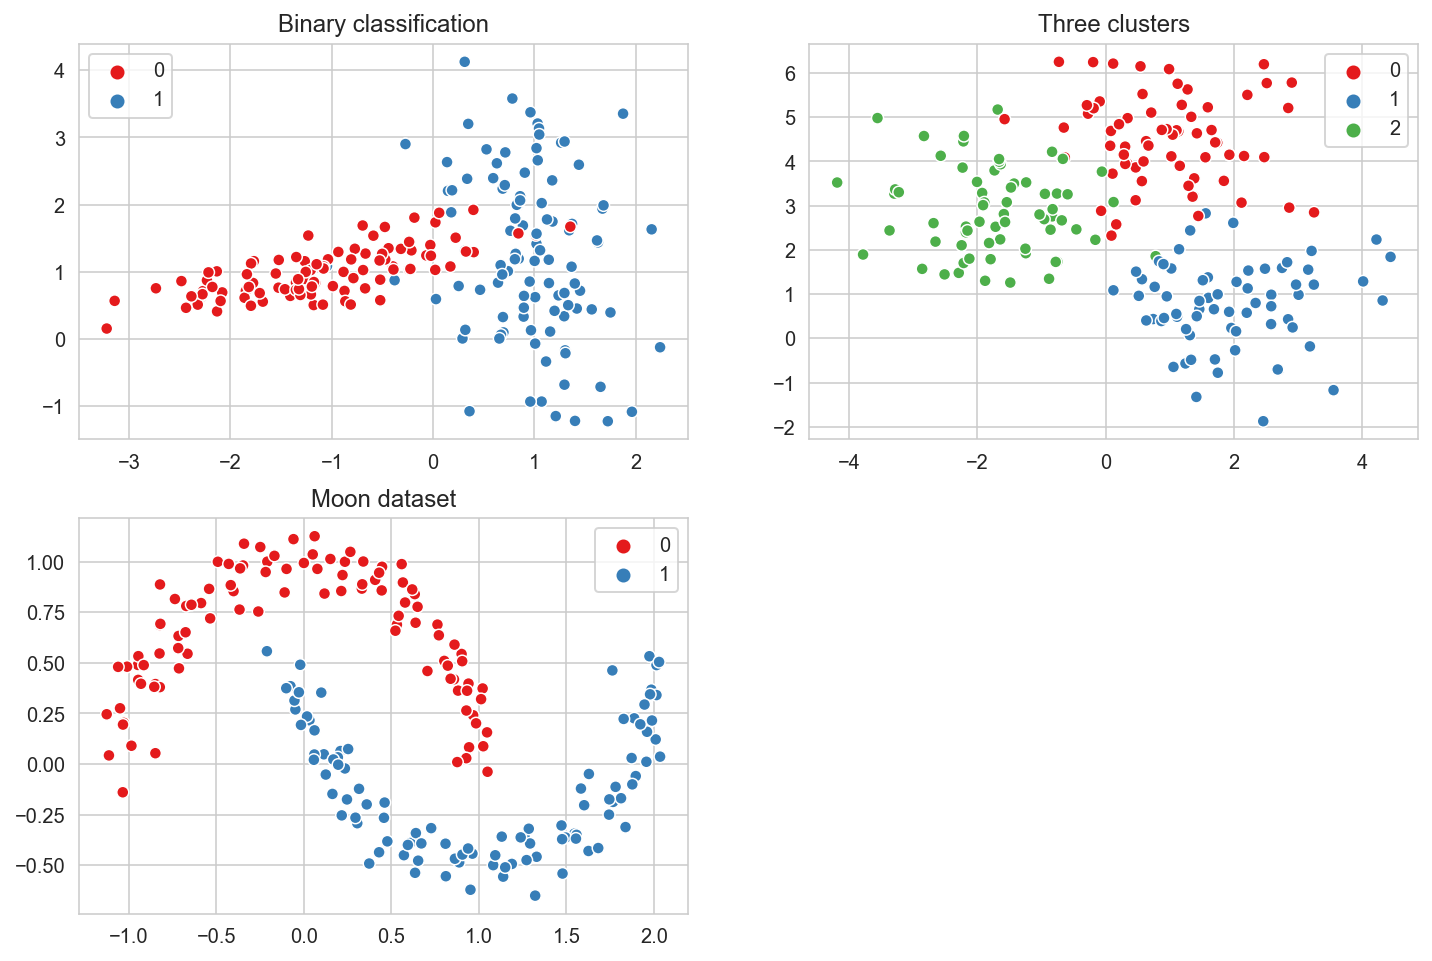

In [4]:
plt.figure(figsize = (12,8))
plt.subplot(221)
sns.scatterplot(X1[:,0], X1[:,1], hue = y1, palette = 'Set1')
plt.title('Binary classification')

plt.subplot(222)
sns.scatterplot(X2[:,0], X2[:,1], hue = y2, palette = 'Set1')
plt.title('Three clusters');

plt.subplot(223)
sns.scatterplot(X3[:,0], X3[:,1], hue = y3, palette = 'Set1')
plt.title('Moon dataset');

## 1.2) Logistic Regression Classifier from scikit-learn
Since this section is an introduction to the use of this classifier, no importance is given to the hyperparameters tuning. The main goal here is to understand the concept of Logistic Regression being a linear classifier ie the decision boundary is a line (or a hyperplane) that best seperates the data, according to the minimization of the logistic loss.

In [5]:
from sklearn.linear_model import LogisticRegression

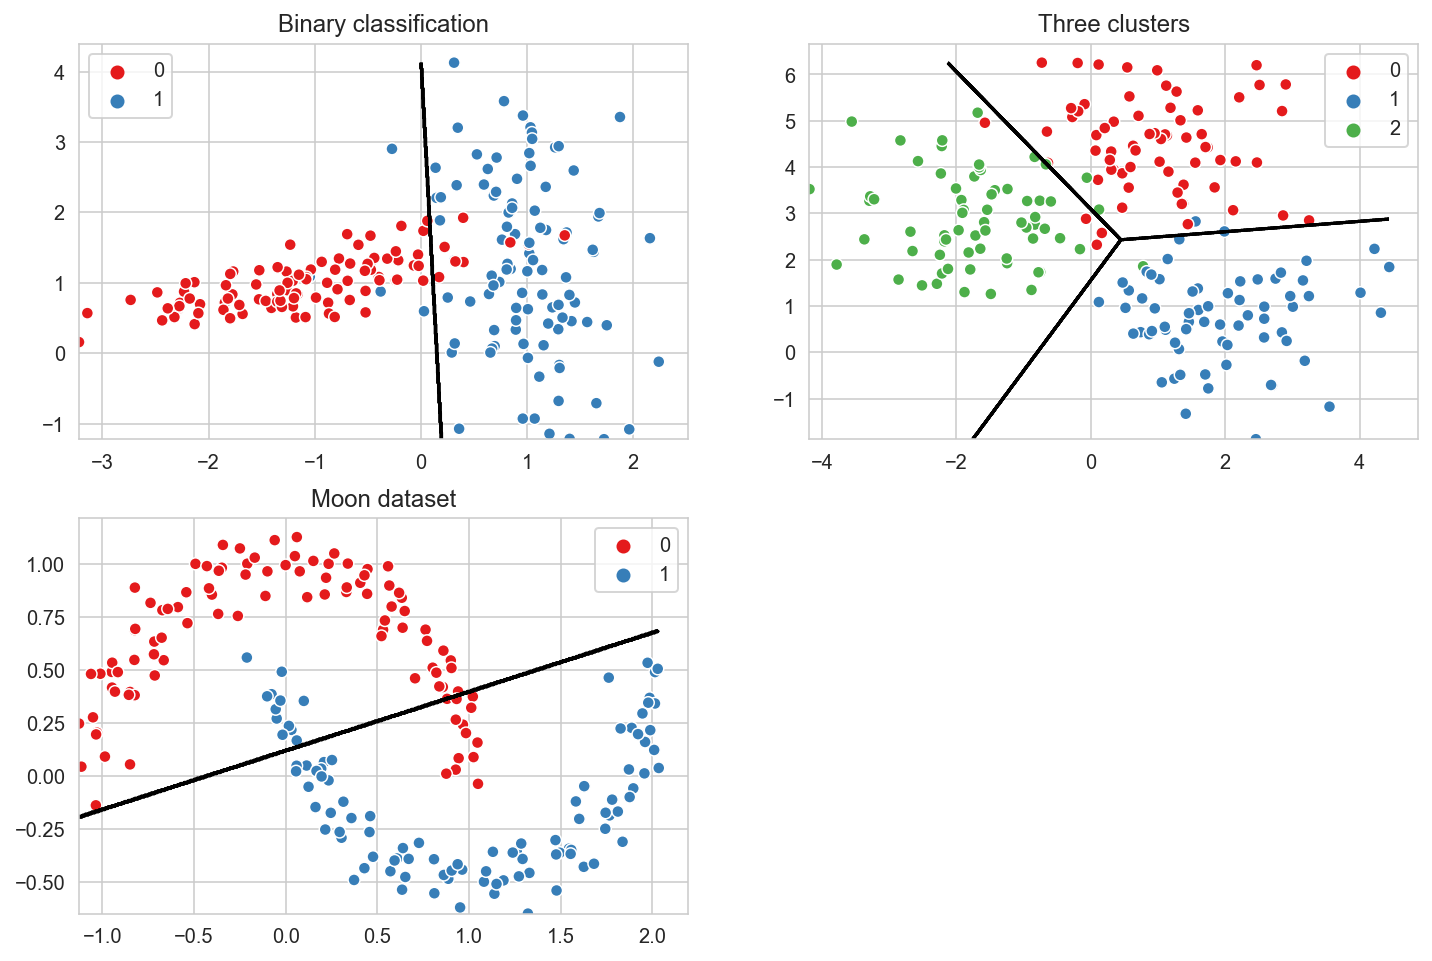

In [6]:
clf1 = LogisticRegression().fit(X1,y1)
clf2 = LogisticRegression().fit(X2,y2)
clf3 = LogisticRegression().fit(X3,y3)

plt.figure(figsize = (12,8))
plt.subplot(221)
#map_regions(clf1, X1)
sns.scatterplot(X1[:,0], X1[:,1], hue = y1, palette = 'Set1')
decision_boundary(X1, clf1)
plt.title('Binary classification')

plt.subplot(222)
#map_regions(clf2, X2)
sns.scatterplot(X2[:,0], X2[:,1], hue = y2, palette = 'Set1')
decision_boundary(X2, clf2)
plt.title('Three clusters');

plt.subplot(223)
#map_regions(clf3, X3)
decision_boundary(X3, clf3)
sns.scatterplot(X3[:,0], X3[:,1], hue = y3, palette = 'Set1')
plt.title('Moon dataset');

It is clearly represented in the figures that the decision boundary is linear. In fact, Logistic Regression is a parametric model, of parameter $\theta$, that returns the probability of a class given the observed data. The linearity is explained by the following equation:
$$
p(y=1 | X = x) = \frac{1}{1+\exp{\theta^TX}}
$$
which can be easily written, via the $logit$ function, as a linear combination of the components of $\theta$.

To better improve the generalization ability of our model, cross-validation has to be performed. In what follows, a simple implementation of a $k$-fold cross-validation is given.
## 1.3) Applying $k$-fold cross-validation

In [7]:
from sklearn.model_selection import KFold

In [8]:
cv = 3
k_fold = KFold(n_splits = 5, random_state = 42, shuffle = True)
clf = LogisticRegression()
lis_X, lis_y = [X1, X2, X3], [y1, y2, y3]

avg_score = []
for X, y in zip(lis_X, lis_y):
    score_kf = []
    for train_idx, test_idx in k_fold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        clf.fit(X_train, y_train)
        score_kf.append(clf.score(X_test, y_test))
    score_kf = np.array(score_kf)
    avg_score.append(np.mean(score_kf))

In [9]:
display(HTML(
    f"Average test scores (5-fold cross-validation): <br/>"
    f"Data set 1: {avg_score[0]} <br/>"
    f"Data set 2: {avg_score[1]} <br/>"
    f"Data set 3: {avg_score[2]} <br/>"
))

The error is the average over all the folds used for cross-validation. This method helps reducing the model's variance and makes it more able to correctly predict unseen data. The next part is about our own implementation of logistics regression.
# 2. Logistic Regression Implementation
___
In this part, a simple implementation is given, the functions below are useful in computing the probability of classes in the cases of binary and multi-class classifications. 

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In this implementation, Stochastic Gradient Descent is preferred to the second order Newton's method, for its time efficiency. Here are some details of the algorithm:
- The `__init__` method is used to initialize the models weights and biases, it takes the number of features, and the number of classes as entry, along with whether the problem is a binary classificattion or not.
- The `forward` method computes the probability of a given class.
- The `predict` method returns the predicted class
- The `fit` method contains the gradient updates, it has to be used in a `for` loop over the batches and the epochs.
- The `accuracy`method computes the model's score.

In [11]:
class LogisticReg():
    
    def __init__(self, input_size, output_size, binary):
        self.w = np.random.randn(input_size, output_size)
        self.b = np.random.randn(output_size)
        self.output_size = output_size
        self.binary = binary
        
        
    def forward(self, X):
        if self.binary == True:
            z = np.dot(X,self.w) + self.b
            return sigmoid(z)
        else:
            z = np.dot(X,self.w) + self.b
            return softmax(z)
            
        
    def predict(self, X):
        y_pred = np.argmax(self.forward(X), axis=1)
        return y_pred
        
        
    def fit(self, X, y, lr):
        y = one_hot(self.output_size, y)
        grad_w = - np.outer(X,y - self.forward(X))
        grad_b = - (y - self.forward(X))
        self.w -= 0.1 * grad_w
        self.b -= 0.1 * grad_b
        
        
    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the implementation is complete, we test it on the initially introduced data sets, and assess our model's performance.
# 3. Test on simulated data sets
___
## 3.1) Binary Classification

In [12]:
# Build a model and test its forward inference
n_features = X1.shape[1]
n_classes = len(np.unique(y1))
lr2 = LogisticReg(n_features, n_classes, binary = True)

train_acc = lr2.accuracy(X1, y1)
display(HTML(
    f"Evaluation of the untrained model: <br/>"
    f"train acc: {train_acc} <br/>"
))

The above accuracy is the one we get with the randomly initialized model, let us see if it does better after training.

In [13]:
# Training for only bone epoch
learning_rate = 0.1

for i, (x, y) in enumerate(zip(X1, y1)):
    lr2.fit(x, y, lr = learning_rate)
    if i % 20 == 0:
        train_acc = lr2.accuracy(X1, y1)
        test_acc = lr2.accuracy(X1, y1)
        display(HTML(
        f"Update {i}: train acc: {train_acc} <br/>"
        ))

We achieve $92.5\%$ accuracy for only one pass over the data set, which is very satisfying. Note that given the nature of the dataset not being linearly seperable, it is impossible, using a linear classifier, to reach a $100\%$  accuracy. 

## 3.2) Multi-class classification
The same procedure is repeated, the error is also computed after only one epoch.

In [14]:
n_features = X2.shape[1]
n_classes = len(np.unique(y2))
lr2 = LogisticReg(n_features, n_classes, binary = False)

train_acc = lr2.accuracy(X2, y2)
display(HTML(
    f"Evaluation of the untrained model: <br/>"
    f"train acc: {train_acc} <br/>"
))

In [15]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X2, y2)):
    lr2.fit(x, y, lr = learning_rate)
    if i % 20 == 0:
        train_acc = lr2.accuracy(X2, y2)
        test_acc = lr2.accuracy(X2, y2)
        display(HTML(
        f"Update {i}: train acc: {train_acc} <br/>"
        ))

We can see that the model quickly learns from the data, since one epoch was sufficient to obtain a high accuracy.

## 3.3) Moon data set
This data set is very hard for linear classifiers, we could expect the model to be not extremely precise.

In [16]:
n_features = X3.shape[1]
n_classes = len(np.unique(y3))
lr2 = LogisticReg(n_features, n_classes, binary = True)

train_acc = lr2.accuracy(X3, y3)
display(HTML(
    f"Evaluation of the untrained model: <br/>"
    f"train acc: {train_acc} <br/>"
))

In [17]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X3, y3)):
    lr2.fit(x, y, lr = learning_rate)
    if i % 20 == 0:
        train_acc = lr2.accuracy(X3, y3)
        test_acc = lr2.accuracy(X3, y3)
        display(HTML(
        f"Update {i}: train acc: {train_acc} <br/>"
        ))

The model still performs well but is severely limited by the nature of the dataset not being linearly seperable. Let us improve our model's generalization ability by applying a k-fold cv.
## 3.4) $k$-fold cross-validation on binary classification data sets $(k=10)$

In [18]:
cv = 10
k_fold = KFold(n_splits = cv, random_state = 42, shuffle = True)
lis_X, lis_y = [X1, X3], [y1, y3]

avg_score = []
for X, y in zip(lis_X, lis_y):
    score_kf = []
    for train_idx, test_idx in k_fold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))
        clf = LogisticReg(n_features, n_classes, binary = True)
        
        learning_rate = 0.01

        for i, (x, yy) in enumerate(zip(X_train, y_train)):
            clf.fit(x, yy, lr = learning_rate)
        
        score_kf.append(clf.accuracy(X_test, y_test))
    score_kf = np.array(score_kf)
    avg_score.append(np.mean(score_kf))

In [19]:
display(HTML(
    f"Average test scores (10-fold cross-validation): <br/>"
    f"Data set 1: {avg_score[0]} <br/>"
    f"Data set 3: {avg_score[1]} <br/>"
))

After training the model on k folds, we expect a better performance on a new test sample.
## 3.5) $k$-fold cross-validation on the multiclass classification data set $(k=10)$

In [20]:
cv = 10
k_fold = KFold(n_splits = cv, random_state = 42, shuffle = True)
lis_X, lis_y = [X2], [y2]

avg_score = []
for X, y in zip(lis_X, lis_y):
    score_kf = []
    for train_idx, test_idx in k_fold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))
        clf = LogisticReg(n_features, n_classes, binary = True)
        
        learning_rate = 0.01

        for i, (x, yy) in enumerate(zip(X_train, y_train)):
            clf.fit(x, yy, lr = learning_rate)
        
        score_kf.append(clf.accuracy(X_test, y_test))
    score_kf = np.array(score_kf)
    avg_score.append(np.mean(score_kf))

In [21]:
display(HTML(
    f"Average test score (10-fold cross-validation): <br/>"
    f"Data set 2: {avg_score[0]} <br/>"
))

The next parts are about mor complicated data sets. The following is a multiclass problem, while the last part is about a binary classification.
# 4. Mice Protein Expression data set
___
The same pre-processing from the older labs is applied here also.

In [22]:
data_mice = pd.read_excel('Data_Cortex_Nuclear.xls', header = 0)
data_mice.drop(columns = ['MouseID'], inplace = True)

In [23]:
display(HTML(
    f"Number of features: {data_mice.shape[1] - 1} <br/>"
    f"Number of experiments: {data_mice.shape[0]} <br/>"))

In [24]:
cat_features = [i for i in data_mice.select_dtypes('object')]
display(HTML(
    f" {[np.unique(data_mice[i]) for i in cat_features]} <br/>"
))

In [25]:
def missing(df):
    miss = (df.isnull().count() - df.count()).sort_values(ascending = False)
    perc = miss / df.isnull().count()
    data_missing = pd.concat([miss, perc], axis = 1, keys = ['total', 'percentage'])
    return data_missing[data_missing.percentage>0]

In [26]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Numerical Preprocessing
num_features = missing(data_mice).index.to_list()
data_mice[num_features] = SimpleImputer(strategy = 'most_frequent').fit_transform(data_mice[num_features])

# Categorical Preprocessing
enc = OrdinalEncoder()
data_mice[cat_features] = enc.fit_transform(data_mice[cat_features]);

In [27]:
data_mice.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,0.0,0.0,0.0,0.0
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,0.0,0.0,0.0,0.0
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,0.0,0.0,0.0,0.0
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,0.0,0.0,0.0,0.0
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,0.0,0.0,0.0,0.0


In [28]:
to_drop = ['class']
y = data_mice['class']
X = data_mice.drop(columns = to_drop)

In [29]:
display(HTML(
    f"Classes: {np.unique(y)} <br/>"
))

We simultaneously train our own model, and the sk-lealrn's with very small regularization. Since we deal with more complicated data sets, more epochs (passes through the whole data set) were needed to achieve high accuracy. We set this number to `epoch = 150`.

In [30]:
cv = 10
k_fold = KFold(n_splits = cv, random_state = 42, shuffle = True)
lis_X, lis_y = [X], [y]
epoch = 150

avg_score, avg_score_sk = [], []
for X, y in zip(lis_X, lis_y):
    
    score_kf, score_kf_sk = [], []
    for train_idx, test_idx in k_fold.split(X):
        X_train, X_test = X.loc[train_idx,:].to_numpy(), X.loc[test_idx,:].to_numpy()
        y_train, y_test = y.loc[train_idx].values, y.loc[test_idx].values
        
        # Training sklearn model
        clf2 = LogisticRegression(penalty = 'l2', C = 1, solver = 'lbfgs', max_iter = 500)
        clf2.fit(X_train, y_train)
        score_kf_sk.append(clf2.score(X_test, y_test))
        
        # Training own model
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))
        clf = LogisticReg(n_features, n_classes, binary = False)
        
        learning_rate = 0.01
        for e in range(epoch):
            for i, (x, yy) in enumerate(zip(X_train, y_train.astype(int))):
                clf.fit(x, yy, lr = learning_rate)

        score_kf.append(clf.accuracy(X_test, y_test))
    
    score_kf, score_kf_sk = np.array(score_kf), np.array(score_kf_sk)
    avg_score.append(np.mean(score_kf))
    avg_score_sk.append(np.mean(score_kf_sk))

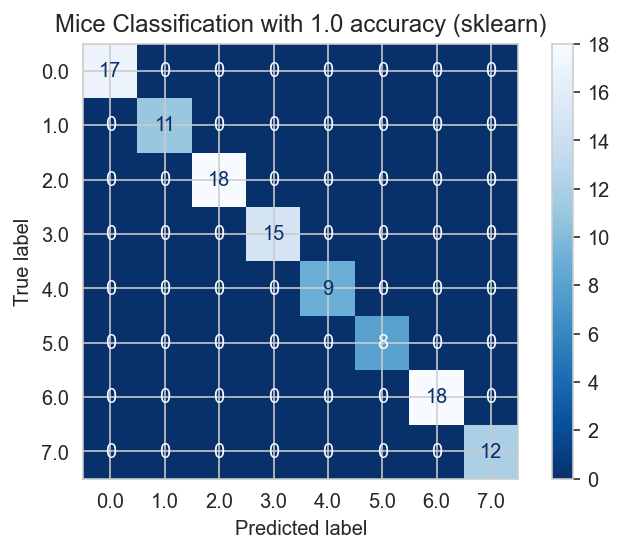

In [31]:
from sklearn.metrics import plot_confusion_matrix

display(HTML(
    f"Average test score (10-fold cv):<br/>"
    f"Own classifier (SGD): {avg_score[0]} <br/>"
    f"SK-learn classifier (Newton): {avg_score_sk[0]} <br/>"
))

plot_confusion_matrix(clf2, X_test, y_test, cmap = 'Blues_r')
plt.title('Mice Classification with {} accuracy (sklearn)'.format(clf2.score(X_test, y_test)));

What is observed is that both models achieve a $100\%$ accuracy and make no mistakes in classifying the mice into their right groups. It turns out that by optimizing the logistic loss, the algorithm was able to determine the right hyperplane that best seperates the data, that appears to be linearly seperable in a $8$-dimensional space.

The last part deals with a 0 1 classification.
# 5. Breast Cancer Diagnosis 
___
The aim is to detect the patiants with high risk of developing Breast Cancer. The same preprocessing as previous labs is also applied here, including data normalization.

In [32]:
breast_cancer = pd.read_table('BreastDiagnostic.txt', sep = ',', header = None)

In [33]:
display(HTML(
    f"Number of attributes: {breast_cancer.shape[1] - 2} <br/>"
    f"Number of patients: {breast_cancer.shape[0]} <br/>"))

In [34]:
y = breast_cancer.loc[:,1]
X = breast_cancer.drop(columns = 1)
y = y.values
y[y=='M'] = 1
y[y=='B'] = 0
y = y.astype(int)

In [35]:
from sklearn.preprocessing import minmax_scale

X = pd.DataFrame(minmax_scale(X))

In [36]:
enc = OrdinalEncoder()
breast_cancer.loc[:,1] = enc.fit_transform(breast_cancer.loc[:,1].to_numpy().reshape(-1,1))

Similar procedure is applied to train both versions of the classifier.

In [37]:
cv = 10
k_fold = KFold(n_splits = cv, random_state = 42, shuffle = True)
lis_X, lis_y = [X], [y]
epoch = 150

avg_score, avg_score_sk = [], []
for X, y in zip(lis_X, lis_y):
    
    score_kf, score_kf_sk = [], []
    for train_idx, test_idx in k_fold.split(X):
        X_train, X_test = X.loc[train_idx,:].to_numpy(), X.loc[test_idx,:].to_numpy()
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Training sklearn model
        clf2 = LogisticRegression(penalty = 'l2', C = 1, solver = 'lbfgs', max_iter = 500)
        clf2.fit(X_train, y_train)
        score_kf_sk.append(clf2.score(X_test, y_test))
        
        # Training own model
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))
        clf = LogisticReg(n_features, n_classes, binary = True)
        
        learning_rate = 0.01
        for e in range(epoch):
            for i, (x, yy) in enumerate(zip(X_train, y_train)):
                clf.fit(x, yy, lr = learning_rate)

        score_kf.append(clf.accuracy(X_test, y_test))
    
    score_kf, score_kf_sk = np.array(score_kf), np.array(score_kf_sk)
    avg_score.append(np.mean(score_kf))
    avg_score_sk.append(np.mean(score_kf_sk))

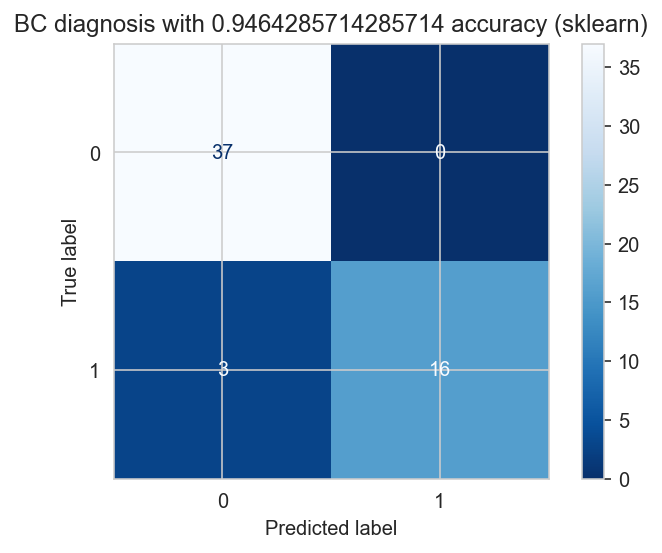

In [38]:
display(HTML(
    f"Average test score (10-fold cv):<br/>"
    f"Own classifier (SGD): {avg_score[0]} <br/>"
    f"Sklearn classifier (Newton): {avg_score_sk[0]} <br/>"
))

plot_confusion_matrix(clf2, X_test, y_test, cmap = 'Blues_r')
plt.title('BC diagnosis with {} accuracy (sklearn)'.format(clf2.score(X_test, y_test)));

Both versions are extremely powerful with very low error rate and achieve a good approximation of the function's minimum. The small differences are due to the initialization which is completely randomized. What is to notice here is that the `lbfgs` solver used in the sk-learn's version approximates the Hessian by using the information of the first order (ie the gradient). The SGD algorithm, used in our own implementation, is a first order method that only uses one data point to compute the update, which makes it extremely fast. In many applications, the SGD algorithm is preferred for its time effectiveness.